This notebook is for analysing the patient presence at the hospitals.

Result should be, for each patient:
- a list of 61 days marked with a 0
- the middle day is matched with the surgery action date and marked with a 1
- any other inpatient or outpatient days for the same case to be marked with a 1
- this yields a square signal for patient's attendance

In [1]:
# All imports
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

### Data File:

In [5]:
FileName = "aaaPas_first_500.pickle"
# Read in Data File
with open(FileName, 'rb') as fHndl:
    df = pickle.load(fHndl)

display(df.head(4))
print("Dataframe shape:\t\t\t{}".format(df.shape))
print("Total number of patients in the data:\t{}\n\n".format(df["val_lopnr"].iloc[-1]))

for slNo, name in enumerate(df.columns):
    print("{}:\t{}".format(slNo, name))


,ID,lopnr,val_lopnr,birth_year_month,Sex,RefActionDate,DocumentID,IsReference,TimestampSaved,SavedAtCareUnitID,...,ActionCode18,ActionCode19,ActionCode20,ActionCode21,ActionCode22,Mosaic,Usaett,LastMoveDate,LastMoveDirection,NumberOfEarlierVisits
0,296473,97508,1,01/08/1942,K,15/03/2020,3277,1,16/03/2020,5091,...,NaN,NaN,NaN,NaN,NaN,1.Bttre bemedlade,1.0,NaN,NaN,8.0
1,294480,97508,1,01/08/1942,K,15/03/2020,3485,0,24/03/2020,4264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
2,293891,97508,1,01/08/1942,K,15/03/2020,3547,0,24/03/2020,5065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
3,296589,97508,1,01/08/1942,K,15/03/2020,3552,0,27/03/2020,5091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


Dataframe shape:			(1351, 80)
Total number of patients in the data:	500


0:	ID
1:	lopnr
2:	val_lopnr
3:	birth_year_month
4:	Sex
5:	RefActionDate
6:	DocumentID
7:	IsReference
8:	TimestampSaved
9:	SavedAtCareUnitID
10:	NameOfCareUnit
11:	IsInpatient
12:	StartDatetime
13:	EmergencyID
14:	DischargeDateTime
15:	DiagnosisCode1
16:	DiagnosisCode2
17:	DiagnosisCode3
18:	DiagnosisCode4
19:	DiagnosisCode5
20:	DiagnosisCode6
21:	DiagnosisCode7
22:	DiagnosisCode8
23:	DiagnosisCode9
24:	DiagnosisCode10
25:	DiagnosisCode11
26:	DiagnosisCode12
27:	DiagnosisCode13
28:	DiagnosisCode14
29:	DiagnosisCode15
30:	DiagnosisCode16
31:	DiagnosisCode17
32:	DiagnosisCode18
33:	DiagnosisCode19
34:	DiagnosisCode20
35:	DiagnosisCodePre1
36:	DiagnosisCodePre2
37:	DiagnosisCodePre3
38:	DiagnosisCodePre4
39:	DiagnosisCodePre5
40:	DiagnosisCodePre6
41:	DiagnosisCodePre7
42:	DiagnosisCodePre8
43:	DiagnosisCodePre9
44:	DiagnosisCodePre10
45:	DiagnosisCodePre11
46:	DiagnosisCodePre12
47:	DiagnosisCodePre13
48:	DiagnosisC

### Make a container to hold square waves.

In [6]:
# Number of patients: last serial number in 'val_lopnr'
# 1 time string per patient
# time string length is 30 days before and after 'RefActionDate' for that patient = when surgery was performed
# time string length = 30 + 30 + 1 = 61
timeStringLen = 61
numPatients = df['val_lopnr'].to_numpy()[-1]+1
timeStrings = np.zeros((numPatients, timeStringLen))
ts = timeStrings[0,:]
print(np.shape(ts))
# print(np.shape(timeStrings))

(61,)


In [7]:
eventStartDates = df.loc[df['val_lopnr']==1]['StartDatetime']
eventEndDates = df.loc[df['val_lopnr']==1]['DischargeDateTime'].fillna(0)

# print(eventStartDates)
# print(eventEndDates)

In [9]:
# Assign a name for RefActionDate 
idx30_date = pd.to_datetime(df.loc[df['val_lopnr']==1]['RefActionDate'][0], dayfirst=True)

# Set midpoint of list to RefActionDate
midPt = 30
ts[midPt] = 1

for i, j in zip(eventStartDates, eventEndDates):
    x = pd.to_datetime(i, dayfirst=True)
    print(x)
    print((x-idx30_date).days)
    startOffset = (x-idx30_date).days
    ts[midPt + startOffset] = 1
    if j!=0: # When inpatient
        y = pd.to_datetime(j, dayfirst=True)
        print(y)
        print('interval is {}'.format((y-x).days))
        endOffset = (y-x).days
        ts[midPt + startOffset : midPt + startOffset + endOffset + 1] = 1
    else: # Delta when outpatient
        print(0)
    print('---')

2020-03-08 00:00:00
-7
2020-03-15 00:00:00
interval is 7
---
2020-03-20 00:00:00
5
0
---
2020-03-21 00:00:00
6
2020-03-23 00:00:00
interval is 2
---
2020-03-23 00:00:00
8
2020-03-26 00:00:00
interval is 3
---


In [10]:
def generateSquareSignals(idx30_date, eventStarts, eventEnds):
    # Set midpoint of list to RefActionDate
    midPt = 30
    ts = np.zeros(61)
    ts[midPt] = 1
    
    for i, j in zip(eventStartDates, eventEndDates):
        x = pd.to_datetime(i, dayfirst=True)
        # print(x)
        # print((x-idx30_date).days)
        startOffset = (x-idx30_date).days
        # Always set event Start Date to 1, whether inpatient or outpatient
        ts[midPt + startOffset] = 1
        if j!=0: # When inpatient
            y = pd.to_datetime(j, dayfirst=True)
            # print(y)
            # print('interval is {}'.format((y-x).days))
            endOffset = (y-x).days
            ts[midPt + startOffset : midPt + startOffset + endOffset + 1] = 1
        else: # Delta when outpatient
            None
            # print(0)
        # print('---')    
    return ts

In [11]:
missingPatients = 0
patientCountBound = 20000# numPatients
for i in range(1, patientCountBound):
    try: 
        # print(i)
        # chunk = df.loc[df['val_lopnr']==i]['RefActionDate'].iloc[0]
        # print(chunk)
        # print(chunk[0])
        idx30_date = pd.to_datetime(df.loc[df['val_lopnr']==i]['RefActionDate'].iloc[0], dayfirst=True)
        # print(idx30_date)
        eventStartDates = df.loc[df['val_lopnr']==i]['StartDatetime']
        eventEndDates = df.loc[df['val_lopnr']==i]['DischargeDateTime'].fillna(0)
        timeStrings[i, :] = generateSquareSignals(idx30_date, eventStartDates, eventEndDates)
    except:
        missingPatients += 1
        # print(i)
print('Total number of missing patients = {}/{}'.format(missingPatients, patientCountBound))

/tmp/ipykernel_25736/1213486742.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventEndDates = df.loc[df['val_lopnr']==i]['DischargeDateTime'].fillna(0)


Total number of missing patients = 19549/20000


(501, 61)


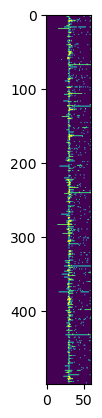

In [12]:
numPatients = 500
print(np.shape(timeStrings))
plt.figure()
plt.imshow(timeStrings[0:max(20, numPatients),:])
plt.show()

In [13]:
import pickle
dataDumpFile = "TimeStrings_20k.pickle"

with open(dataDumpFile, 'wb') as fh:
    pickle.dump(timeStrings, fh)

### TODO
1. Clean up the dataframe of missing serial numbers
2. Find a better plotting to visualise all the timeStrings together